In [1]:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
# Libraries
from numpy.fft import fft
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler

import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

train = pd.read_csv('X_train.csv')
test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
train.shape, y_train.shape


/Users/trentjohnson/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


((487680, 13), (3810, 3))

In [2]:

y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [3]:
y_train.surface.value_counts() 

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [4]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


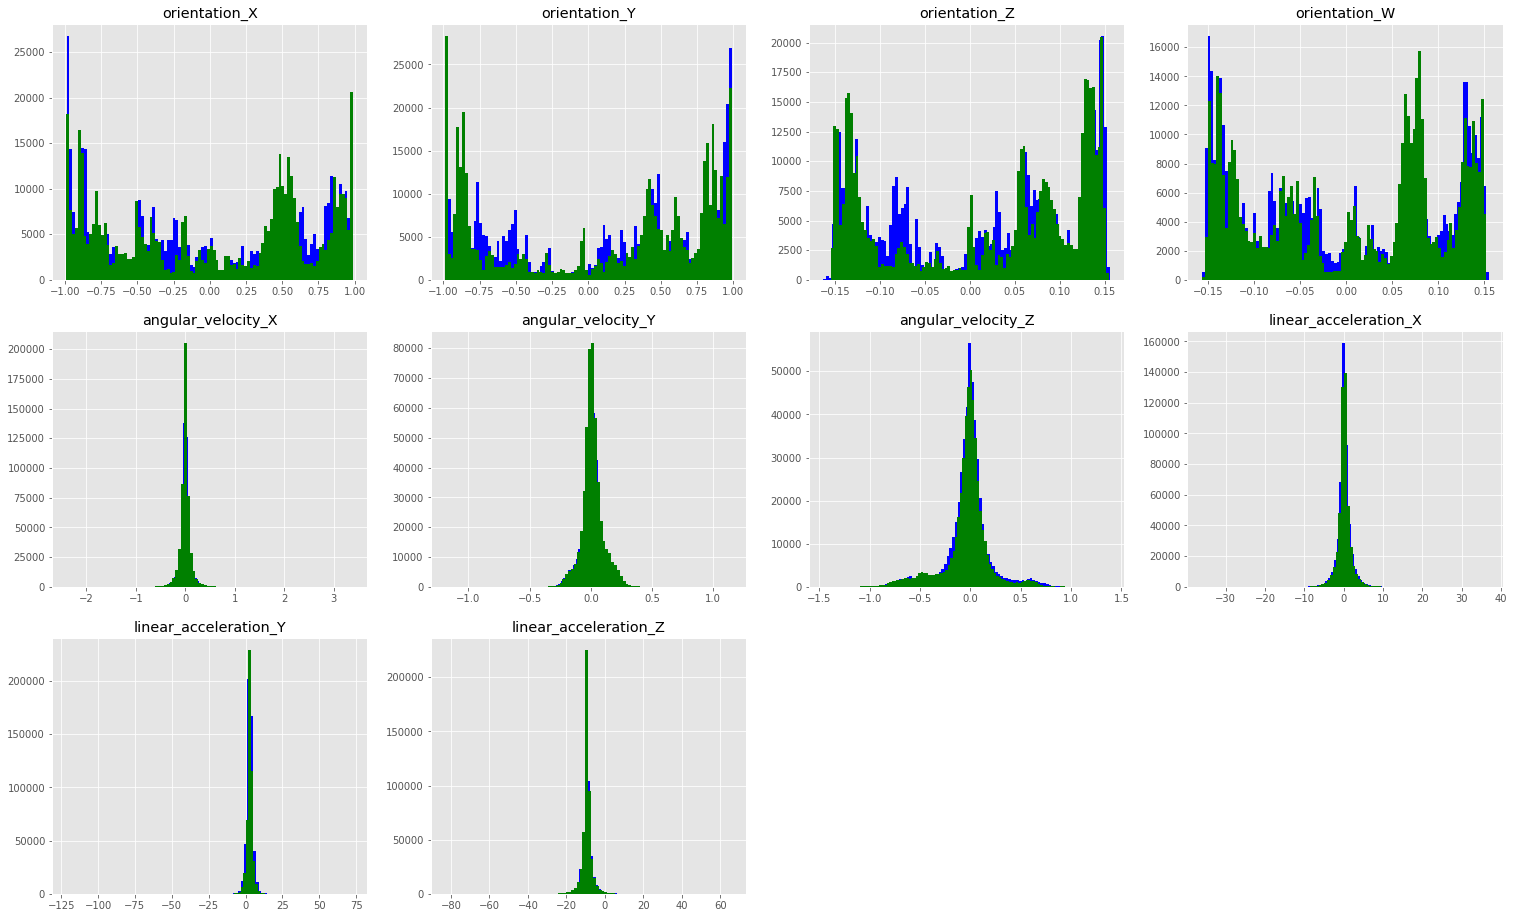

In [5]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(train[col], color='blue', bins=100)
    plt.hist(test[col], color='green', bins=100)
    plt.title(col)

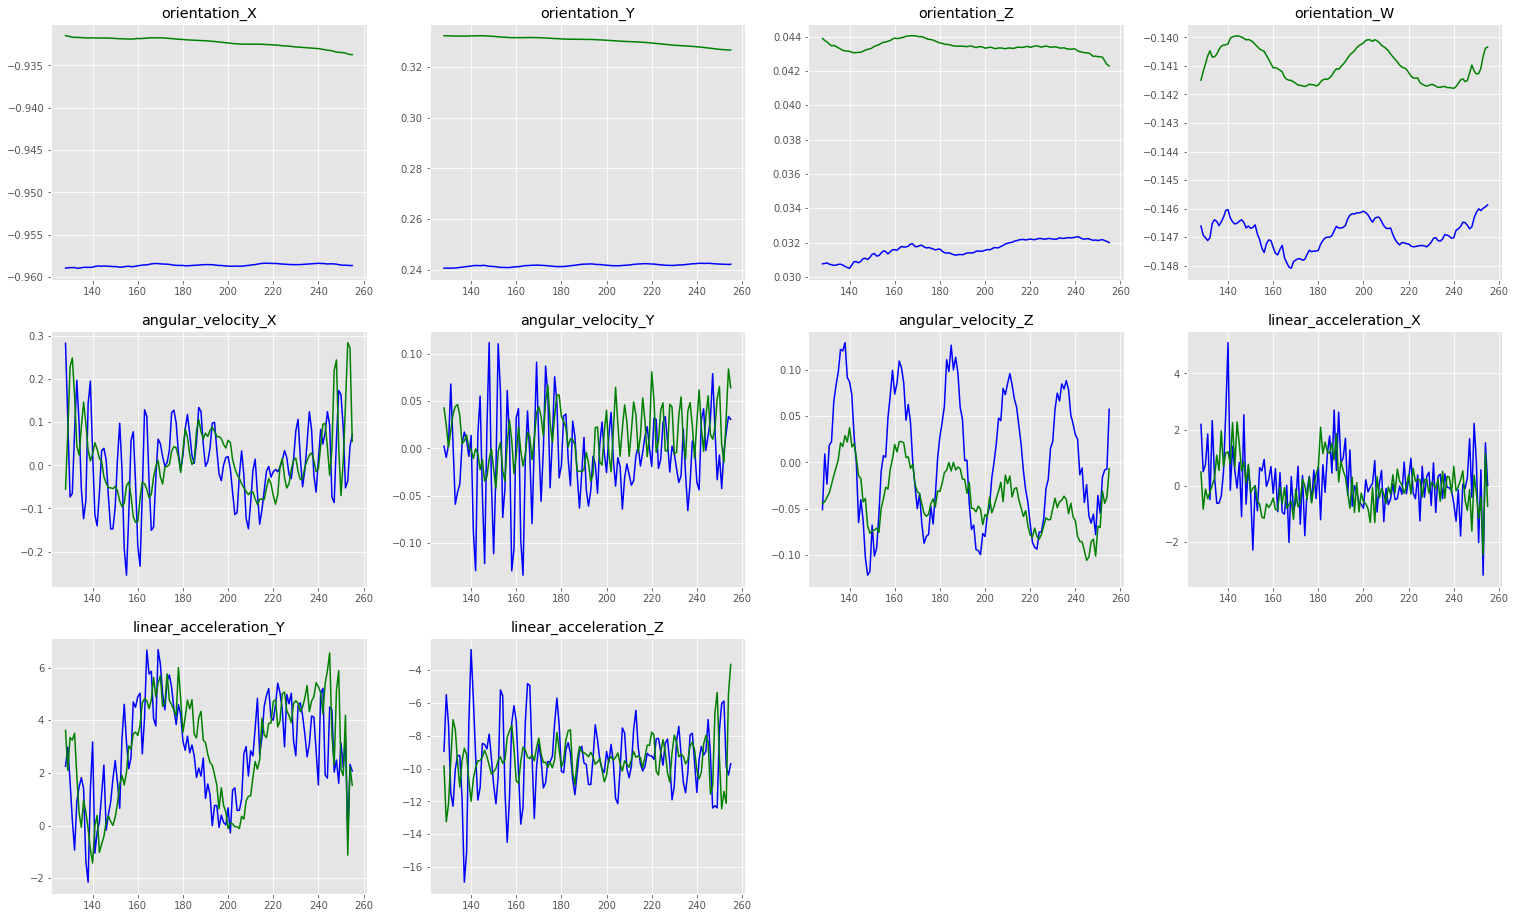

In [6]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 1, col], color='blue')
    plt.plot(test.loc[test['series_id'] == 1, col], color='green')
    plt.title(col)

<Figure size 432x288 with 0 Axes>

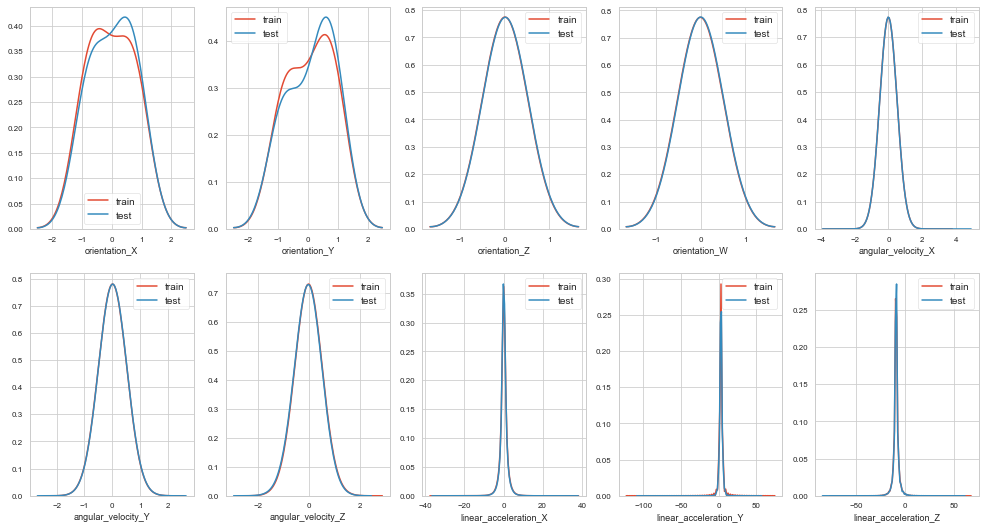

In [7]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()
features = train.columns.values[3:]
plot_feature_distribution(train, test, 'train', 'test', features)
    

In [10]:
def make_class_key(key,classs):
    class_key = []
    for value in key['surface']==classs:
        class_key += [value]*128
    return class_key

def plot_class_feature_distribution(df, key, label, features, classes, a=5, b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,36))
    #df = pd.DataFrame(scaler.transform(df),columns=df.columns)
    
    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for classs in classes:
            class_key = make_class_key(key,classs)
            class_df = df.loc[class_key,:]
            sns.kdeplot(class_df[feature], bw=0.5,label=classs)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        leg = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    plt.subplots_adjust(hspace = .8)
    plt.show()


<Figure size 432x288 with 0 Axes>

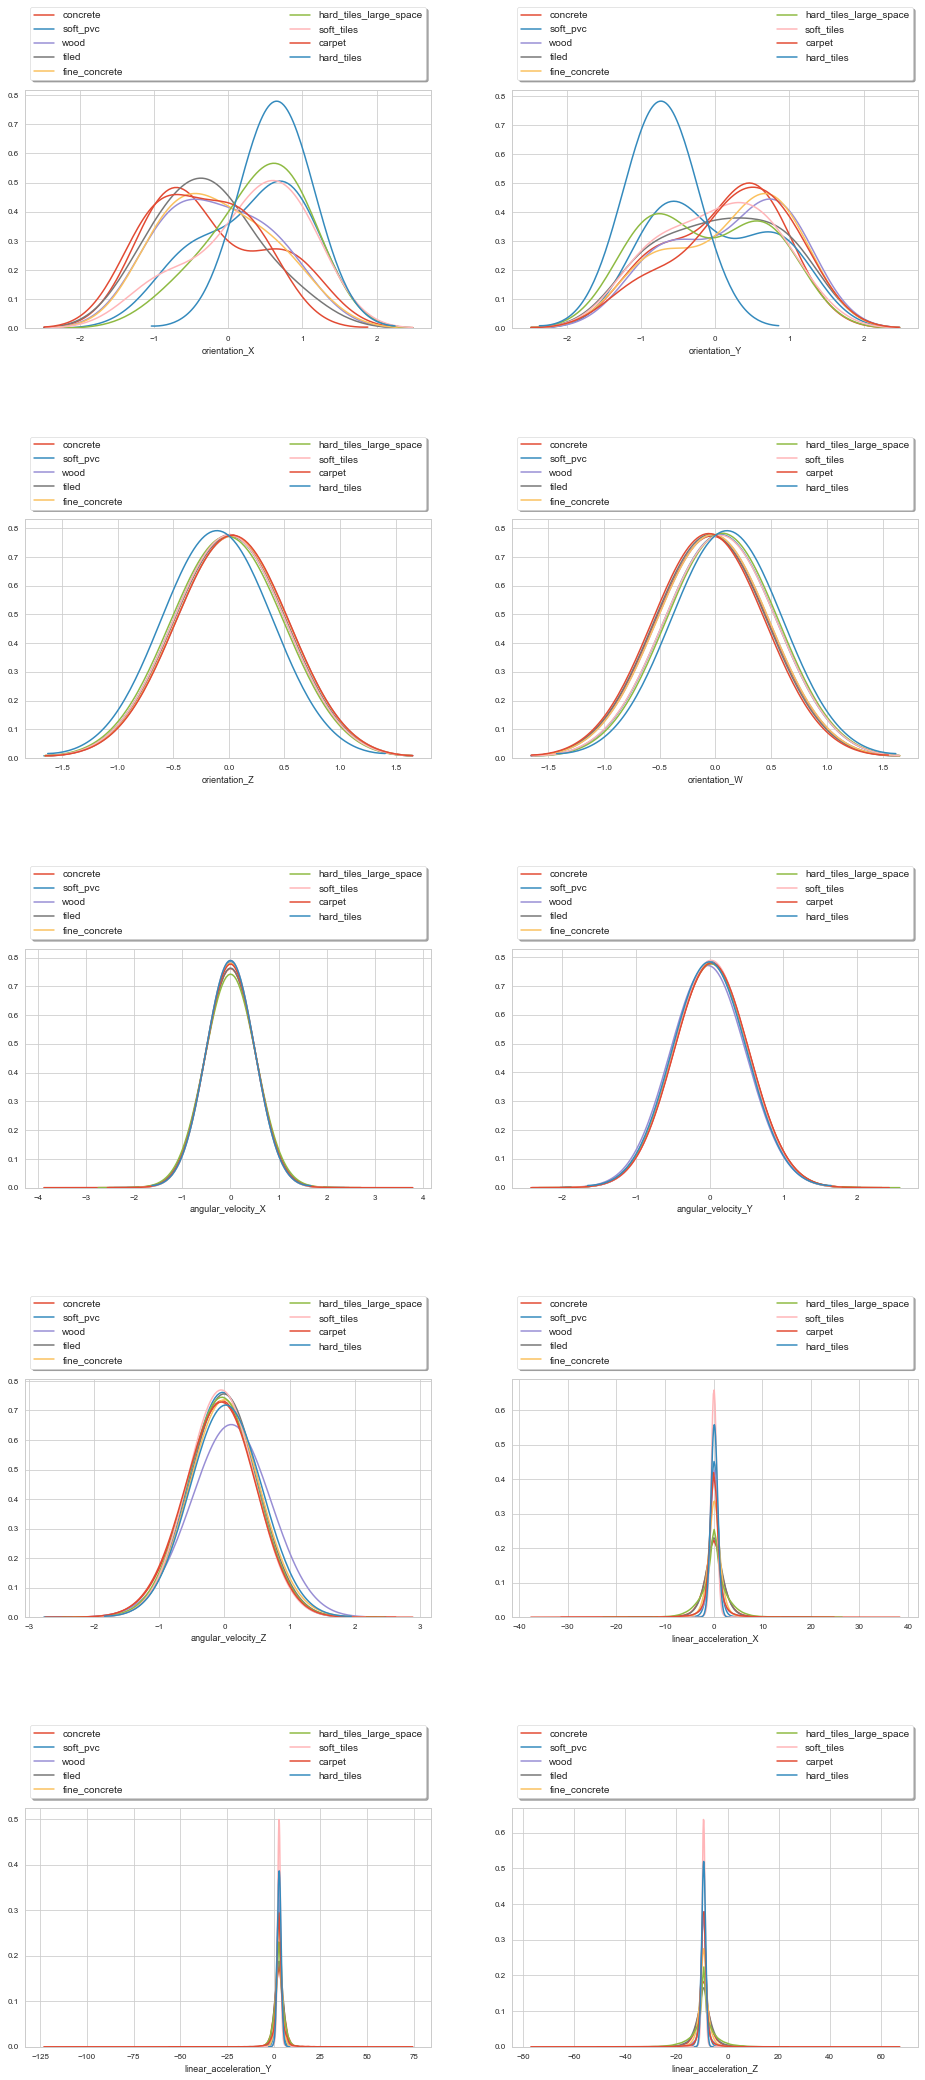

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(test[3:])
features = train.columns.values[3:]
classes = y_train.surface.value_counts().index
plot_class_feature_distribution(train, y_train, 'train', features, classes)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(test[3:])
features = train.columns.values[3:]

strain = pd.DataFrame(scaler.transform(train),columns=train.columns)
stest = pd.DataFrame(scaler.transform(test),columns=train.columns)

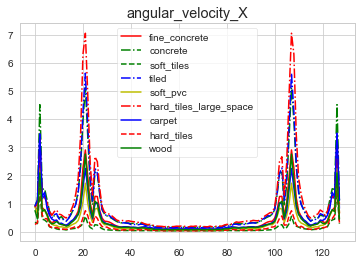

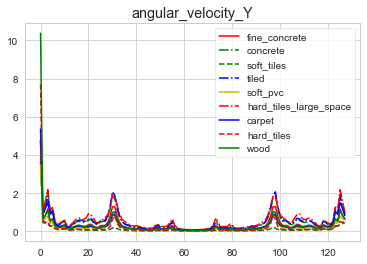

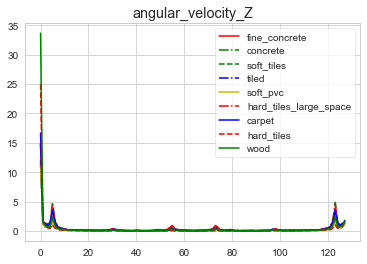

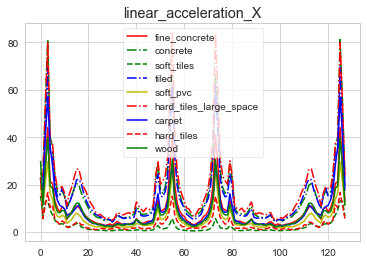

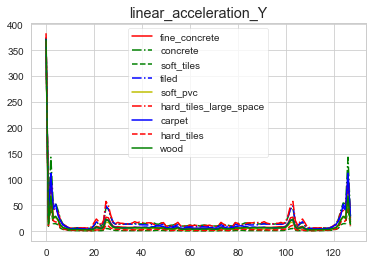

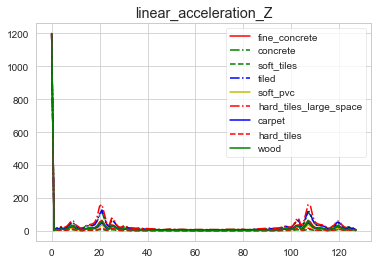

In [13]:
display={
'hard_tiles_large_space':'r-.',
'concrete':'g-.',
'tiled':'b-.',
'fine_concrete':'r-',
'wood':'g-',
'carpet':'b-',
'soft_pvc':'y-',
'hard_tiles':'r--',
'soft_tiles':'g--',
}
sensors = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
g_train = train.groupby('series_id')
g_test = test.groupby('series_id')

for sensor in sensors:
    for surface in y_train['surface'].unique():
        surface_list = []
        for group in g_train.groups:
            right_surface = y_train.loc[group,'surface'] == surface
            if right_surface:
                sub_train = g_train.get_group(group)
                surface_list.append(np.absolute(fft(sub_train[sensor])))
            #print(np.array(surface_list).shape, np.mean(surface_list,axis=0).shape)
            #print(np.array(surface_list).shape)
        surface_list2 = np.mean(surface_list,axis=0)
        plt.plot(surface_list2,display[surface], label=surface)
    plt.title(sensor)
    plt.legend()
    plt.show()
        

In [14]:
def add_freqs(data, cols, id_col='series_id'):
    lables = []
    freq_data = []
    start = time.time()
    markers = [i/10 for i in range(10)]
    for series in data[id_col].unique():
        
        done = series/(1+data[id_col].unique()[-1])
        if len(markers) > 0 and done > markers[0]:
            print('Percent Done:',done)
            print('Runtime:',int(time.time()-start)/60,'min')
            print('Time Left',(1-done)/(done/((time.time()-start)/60)),'min\n')
            markers = markers[1:]
        
        col_data = []
        for col in sensors:
            #print(data.loc[data[id_col]==series,col])
            col_data.append(np.abs(fft(data.loc[data[id_col]==series,col])))
        lables.append(col+'_freq')
        freq_data.append(np.array(col_data).T)
    print(np.array(freq_data).shape)
    return np.array(freq_data)
ftrain = add_freqs(train,sensors)
ftest = add_freqs(test,sensors)


Percent Done: 0.00026246719160104987
Runtime: 0.0 min
Time Left 0.8698432842890422 min

Percent Done: 0.10026246719160105
Runtime: 0.03333333333333333 min
Time Left 0.3847787899080579 min

Percent Done: 0.20026246719160104
Runtime: 0.08333333333333333 min
Time Left 0.34173734947394574 min

Percent Done: 0.30026246719160105
Runtime: 0.11666666666666667 min
Time Left 0.297883905543314 min

Percent Done: 0.400262467191601
Runtime: 0.16666666666666666 min
Time Left 0.25557894943841825 min

Percent Done: 0.5002624671916011
Runtime: 0.2 min
Time Left 0.21278801818292598 min

Percent Done: 0.600262467191601
Runtime: 0.25 min
Time Left 0.17041356773630834 min

Percent Done: 0.700262467191601
Runtime: 0.2833333333333333 min
Time Left 0.12807075483449876 min

Percent Done: 0.8002624671916011
Runtime: 0.3333333333333333 min
Time Left 0.08546839903466254 min

Percent Done: 0.9002624671916011
Runtime: 0.38333333333333336 min
Time Left 0.04267363425478179 min

(3810, 128, 6)
Percent Done: 0.00026205

In [15]:
def flat(data, cols, id_col='series_id'):
    lables = []
    freq_data = []
    start = time.time()
    markers = [i/10 for i in range(10)]
    for series in data[id_col].unique():
        
        done = series/(1+data[id_col].unique()[-1])
        if len(markers) > 0 and done > markers[0]:
            print('Percent Done:',done)
            print('Runtime:',int(time.time()-start)/60,'min')
            print('Time Left',(1-done)/(done/((time.time()-start)/60)),'min\n')
            markers = markers[1:]
        
        col_data = []
        for col in sensors:
            #print(data.loc[data[id_col]==series,col])
            col_data.append(data.loc[data[id_col]==series,col])
        lables.append(col+'_freq')
        freq_data.append(np.array(col_data).T)
    print(np.array(freq_data).shape)
    return np.array(freq_data)

x_train = flat(train,sensors)
x_test = flat(test,sensors)
x_train.shape

Percent Done: 0.00026246719160104987
Runtime: 0.0 min
Time Left 0.8060315688451132 min

Percent Done: 0.10026246719160105
Runtime: 0.03333333333333333 min
Time Left 0.38883251394900975 min

Percent Done: 0.20026246719160104
Runtime: 0.08333333333333333 min
Time Left 0.3436588541864568 min

Percent Done: 0.30026246719160105
Runtime: 0.11666666666666667 min
Time Left 0.3032562427240097 min

Percent Done: 0.400262467191601
Runtime: 0.16666666666666666 min
Time Left 0.2590667258976587 min

Percent Done: 0.5002624671916011
Runtime: 0.2 min
Time Left 0.21570108369665156 min

Percent Done: 0.600262467191601
Runtime: 0.25 min
Time Left 0.1723924539419674 min

Percent Done: 0.700262467191601
Runtime: 0.3 min
Time Left 0.12915832182873732 min

Percent Done: 0.8002624671916011
Runtime: 0.3333333333333333 min
Time Left 0.08596045167456298 min

Percent Done: 0.9002624671916011
Runtime: 0.38333333333333336 min
Time Left 0.04289005683161194 min

(3810, 128, 6)
Percent Done: 0.0002620545073375262
Runt

(3810, 128, 6)

In [17]:
fscaler = StandardScaler()
fscaler.fit(test[3:])

sftrain = pd.DataFrame(fscaler.transform(ftrain))
sftest = pd.DataFrame(fscaler.transform(ftest))

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [ ]:
strain.shape

In [ ]:
train.drop(['orientation_X','orientation_Y', 'orientation_Z', 'orientation_W'], axis=1,inplace=True)
test.drop(['orientation_X','orientation_Y', 'orientation_Z', 'orientation_W'], axis=1,inplace=True)

In [ ]:
train.head()

In [ ]:
display={
'hard_tiles_large_space':'r-.',
'concrete':'g-.',
'tiled':'b-.',
'fine_concrete':'r-',
'wood':'g-',
'carpet':'b-',
'soft_pvc':'y-',
'hard_tiles':'r--',
'soft_tiles':'g--',
}
sensors = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
g_train = train.groupby('series_id')
g_test = test.groupby('series_id')

In [ ]:

for sensor in sensors:
    for surface in y_train['surface'].unique():
        surface_list = []
        for group in g_train.groups:
            right_surface = y_train.loc[group,'surface'] == surface
            if right_surface:
                sub_train = g_train.get_group(group)
                surface_list.append(np.absolute(fft(sub_train[sensor])))
            #print(np.array(surface_list).shape, np.mean(surface_list,axis=0).shape)
            #print(np.array(surface_list).shape)
        surface_list2 = np.mean(surface_list,axis=0)
        plt.plot(surface_list2,display[surface], label=surface)
    plt.title(sensor)
    plt.legend()
    plt.show()
        

In [ ]:
def add_freqs(data, cols, id_col='series_id'):
    lables = []
    freq_data = []
    start = time.time()
    markers = [i/10 for i in range(10)]
    for series in data[id_col].unique():
        
        done = series/(1+data[id_col].unique()[-1])
        if len(markers) > 0 and done > markers[0]:
            print('Percent Done:',done)
            print('Runtime:',int(time.time()-start)/60,'min')
            print('Time Left',(1-done)/(done/((time.time()-start)/60)),'min\n')
            markers = markers[1:]
        
        col_data = []
        for col in sensors:
            #print(data.loc[data[id_col]==series,col])
            col_data.append(np.abs(fft(data.loc[data[id_col]==series,col])))
        lables.append(col+'_freq')
        freq_data.append(np.array(col_data).T)
    print(np.array(freq_data).shape)
    return np.array(freq_data)
ftrain = add_freqs(train,sensors)
ftest = add_freqs(test,sensors)


In [ ]:
#import time
#def make_flat(data,group_id = 'series_id',start_with='angular_velocity_X'):
#    fdata = []
#    start = time.time()
#    markers = [i/10 for i in range(10)]
#    for group in data[group_id].unique():
#       done = group/(1+data[group_id].unique()[-1])
#        if len(markers) > 0 and done > markers[0]:
#            print('Percent Done:',done)
#            print('Runtime:',int(time.time()-start)/60,'min')
#            print('Time Left',(1-done)/(done/((time.time()-start)/60)),'min\n')
#            markers = markers[1:]
#        temp_flat = []
#        temp_group = data.loc[data[group_id]==group,:]
#        temp_group.drop(group_id, axis=1, inplace=True)
#        fdata.append(np.array(temp_flat))
#    return pd.DataFrame(fdata,index=[i for i in range(len(data[group_id].unique()))])
#x_train = make_flat(train)
#x_test = make_flat(test)
#print(train.shape)
#train.head()

In [ ]:
def flat(data, cols, id_col='series_id'):
    lables = []
    freq_data = []
    start = time.time()
    markers = [i/10 for i in range(10)]
    for series in data[id_col].unique():
        
        done = series/(1+data[id_col].unique()[-1])
        if len(markers) > 0 and done > markers[0]:
            print('Percent Done:',done)
            print('Runtime:',int(time.time()-start)/60,'min')
            print('Time Left',(1-done)/(done/((time.time()-start)/60)),'min\n')
            markers = markers[1:]
        
        col_data = []
        for col in sensors:
            #print(data.loc[data[id_col]==series,col])
            col_data.append(data.loc[data[id_col]==series,col])
        lables.append(col+'_freq')
        freq_data.append(np.array(col_data).T)
    print(np.array(freq_data).shape)
    return np.array(freq_data)

x_train = flat(train,sensors)
x_test = flat(test,sensors)
x_train.shape

In [ ]:
from keras.layers import Input,Dense, Dropout, BatchNormalization, SeparableConv1D, Reshape, LSTM, DepthwiseConv2D,AveragePooling2D, CuDNNLSTM, Concatenate
from keras.models import Model
from keras.backend import squeeze
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation
from keras.optimizers import adam
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization,Dropout
from keras.activations import softmax

from sklearn.model_selection import StratifiedKFold
from keras.initializers import glorot_normal
from sklearn.preprocessing import OneHotEncoder

kr = None
num_groups = np.unique(x_train).shape[0]
num_surfaces = 9

def get_base_model(dp):
    inputs_t = Input(shape=(x_train.shape[1],x_train.shape[2]))
    x = SeparableConv1D(32,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(inputs_t)
    x = Dropout(dp)(x)
    x = SeparableConv1D(64,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(256,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Reshape((256,))(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu')(x)
    
    inputs_f = Input(shape=(ftrain.shape[1],ftrain.shape[2]))
    y = SeparableConv1D(32,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(inputs_f)
    y = Dropout(dp)(y)
    y = SeparableConv1D(64,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(256,8,2,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Reshape((256,))(y)
    y = Dropout(dp)(y)
    y = Dense(64, activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = Dense(64, activation='relu')(y)
    
        
    inputs = [inputs_t,inputs_f]
    z = Concatenate()([x,y])
    z = Dense(64, activation='relu')(z)
    predictions = Dense(num_surfaces, activation='softmax')(z)
    model = Model(inputs=inputs, outputs=predictions,)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])
    print(model.metrics_names)
    return model

def get_net_with_params(dp,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,xx,yy,z,aa,bb,cc,dd,ee,ff):
    inputs_t = Input(shape=(x_train.shape[1],x_train.shape[2]))
    x = SeparableConv1D(a,b,c,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(inputs_t)
    x = Dropout(dp)(x)
    x = SeparableConv1D(d,e,f,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(g,h,i,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(j,k,l,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(x)
    x = Reshape((-1,))(x)
    x = Dropout(dp)(x)
    x = Dense(m, activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = Dense(n, activation='relu')(x)
    
    inputs_f = Input(shape=(ftrain.shape[1],ftrain.shape[2]))
    y = SeparableConv1D(o,p,q,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(inputs_f)
    y = Dropout(dp)(y)
    y = SeparableConv1D(r,s,t,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(u,v,w,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(xx,yy,z,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(aa,bb,cc,'same',depth_multiplier=1,activation='relu',kernel_regularizer=kr)(y)
    y = Reshape((-1,))(y)
    y = Dropout(dp)(y)
    y = Dense(dd, activation='relu',kernel_regularizer=kr)(y)
    y = Dropout(dp)(y)
    y = Dense(ee, activation='relu')(y)
    
        
    inputs = [inputs_t,inputs_f]
    z = Concatenate()([x,y])
    z = Dense(ff, activation='relu')(z)
    predictions = Dense(num_surfaces, activation='softmax')(z)
    model = Model(inputs=inputs, outputs=predictions,)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])
    print(model.metrics_names)
    return model

In [ ]:
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = XGBRegressor(params)
    model = lgb.fit(params
                      , xgb.DMatrix(trn_x), xgb.DMatrix(trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [xgb.DMatrix(val_x), xgb.DMatrix(val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [xgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

In [ ]:
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

In [ ]:
from catboost import CatBoostRegressor

def cat_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    model = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
    model.fit(trn_x, trn_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=False)
    
    val_pred = model.predict(val_x)
    test_pred = model.predict(test)
    
    return {'val':val_pred, 
            'test':test_pred, 
            'error':model.get_best_score()['validation']['RMSE']}

In [ ]:
from datetime import datetime
result_dict = dict()
val_pred = np.zeros(train_x.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False
final_errs = []
for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")

    trn_x = X.iloc[trn]
    trn_y = y.iloc[trn]
    #print(trn_y)
    val_x = X.iloc[val]
    val_y = y.iloc[val]
    

    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    test=test
    #""" xgboost
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    xgb_result = result
    fold_val_pred = result['val']*0.2
    #print(fold_val_pred)
    fold_test_pred.append(result['test']*0.2)
    fold_err.append(result['error'])
    print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm  '+str(int((datetime.now()-start).seconds%60))+'s)')
    #"""
    
    #""" lightgbm
    start = datetime.now()
    result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred += result['val']*0.4
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("lgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm  '+str(int((datetime.now()-start).seconds%60))+'s)')
    #"""
    #print(fold_val_pred)
    #""" catboost model
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred += result['val']*0.4
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("cat model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm  '+str(int((datetime.now()-start).seconds%60))+'s)')
    #"""
    #print(fold_val_pred)
    # mix result of multiple models
    val_pred[val] += np.mean(np.array(fold_val_pred), axis = 0)
 
    test_pred += np.mean(np.array(fold_test_pred), axis = 0) / k
    final_err += (sum(fold_err) / len(fold_err)) / k
    final_errs.append(np.sqrt(np.mean((np.array(fold_val_pred)- val_y)**2)))
    print("---------------------------")
    print("avg   err.", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
    print("blend err.", "{0:.5f}".format(np.sqrt(np.mean((np.array(fold_val_pred)- val_y)**2))))
    
    print('')
    
print("final avg blend err.", np.mean(final_errs))


In [ ]:
enc.fit(np.array(y_train.surface).reshape((-1,1)))
y_enc = enc.transform(np.array(y_train.surface).reshape((-1,1))).toarray()
model = get_base_model(0.25)
start = time.time()
history = model.fit([x_train,ftrain], [y_enc], batch_size=64, epochs=1024, verbose=1)
print("Runtime:",int((time.time()-start)/60),'min')
scores = model.evaluate([X_val,fX_val], y_val, verbose=0)
print("cat_accuracy:",scores[1])
sub = model.predict([x_test,ftest])

In [ ]:
sub = enc.inverse_transform(model.predict([x_test,ftest]))
sub2 = []
for i in range(len(sub)):
    sub2.append([i,sub[i][0]])
sub2 = pd.DataFrame(sub2)
sub2.head()

In [ ]:
sub2.to_csv('base_net.csv',header=["series_id","surface"],index=False,)
